# Prerequisites

Neural networks have four building blocks that define how the network operates and how it is trained. As the network architectures have become increasingly complex the details of how the networks are trained have similarly increased, how large the mini batches are, what optimizer to use etc. For instance, see `RoBERTa: A Robustly Optimized BERT Pretraining Approach` (https://arxiv.org/abs/1907.11692).

The four main components of a trained neural network are

- the network architecture
    - feed forward, recurrent, transformer?
    - how many layers?
    - how wide are the layers?
- the optimizer
    - SGD
    - Adam
    - AdamW
- the scheduler
    - constant
    - slanted learning rates
- the learning objective and loss function
    - this is problem dependent
    - masked language model (MLM)
    - causal language model (CLM)
    - translation language model (TLM)
    - classification


https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html


## Network Architecture

The networks architecture is perhaps the most visible part of the four. It defines how the individual (artificial) neurons work and how they connect together. At its simplest the network is a fully connected feed forward network with sigmoid as the activation function for the neurons.

In [103]:
import torch
from torch import nn
from torch.nn import functional as F

class FeedForward(nn.Module):
    def __init__(self, layers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features)
                                     for (in_features, out_features) in layers])
        self.activations = nn.ModuleList([torch.nn.Sigmoid() for _ in layers])

    def forward(self, X, labels=None):
        output = None
        for i_layer, (layer, act) in enumerate(zip(self.layers, self.activations)):
            if output is None:
                output = act(layer(X))
            else:
                output = act(layer(output))
        # do softmax
        prob = F.log_softmax(output, dim=1).exp()
        return prob


n_classes = 2
n_features = 50
layer_spec = [(n_features, 25), (25, n_classes)]
ff = FeedForward(layers=layer_spec)

inputs = torch.randn((10, n_features), dtype=torch.float32)
ff(inputs).detach().numpy()

array([[0.50876135, 0.49123868],
       [0.4975644 , 0.5024356 ],
       [0.5102277 , 0.48977232],
       [0.5089147 , 0.49108538],
       [0.50436974, 0.4956302 ],
       [0.49934506, 0.50065494],
       [0.49872625, 0.50127375],
       [0.5024991 , 0.4975009 ],
       [0.4910561 , 0.5089439 ],
       [0.50821185, 0.49178815]], dtype=float32)

# Let's first load some data

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X, y = make_blobs(n_samples=500, n_features=n_features, centers=2)
X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
sampler = RandomSampler(train_dataset)
train_data = DataLoader(train_dataset, sampler=sampler, batch_size=8)

model = FeedForward(layer_spec)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = LambdaLR(optimizer, lambda epoch: 1e-3)

model.train()
n_epochs = 150
losses = []
for i_epoch in range(n_epochs):
    optimizer.zero_grad()
    for x_, y_ in train_data:
        # Forward pass
        y_pred = model(x_)
    
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        scheduler.step()
    

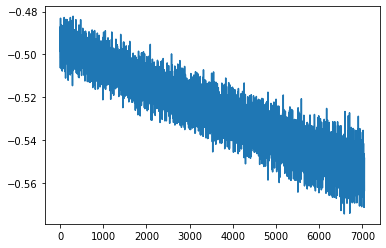

In [161]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.plot(losses)

In [4]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(data_home='./data', remove=('headers', 'footers', 'quotes'))

In [2]:
news.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [24]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  650M  100  650M    0     0   9.8M      0  0:01:05  0:01:05 --:--:-- 12.3M00:59  0:00:18  0:00:41 12.1M01:01  0:00:42  0:00:19 8028k


In [25]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


# Word vectors (fastText)

Much has been said about word vectors, and as a result I won't go into a lot of detail here, but instead simply refer to the existing excellent resources that are already available.

LINK HERE ABOUT WORD VECTORS

In short word vectors are a way of capturing and representing information about distribution semantics in a way that is convenient for computers to deal with. More to the point, they allow arithmetic operations that are, at least to an extent, semantically coherent.

In [26]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [48]:
model.most_similar('king')

[('kings', 0.7969564199447632),
 ('queen', 0.763853907585144),
 ('monarch', 0.7399972081184387),
 ('King', 0.7281952500343323),
 ('prince', 0.7132730484008789),
 ('kingdom', 0.7014780044555664),
 ('ruler', 0.6777099967002869),
 ('royal', 0.6696850061416626),
 ('emperor', 0.6599918603897095),
 ('uncrowned', 0.6499435305595398)]

---

Turn the data into something that can be fed into a network.

In [19]:
news['target_names'][:3], news['target'][:3]

(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc'], array([7, 4, 4]))

we set the vector for out-of-vocabulary words to the mean of all other vectors

In [50]:
unk_vector = model.vectors.mean(axis=0)

In [72]:
def tokenize(msg):
    tokens = re.findall('\w+', msg)
    vectors = [model[t] if t in model else unk_vector for t in tokens][:100]
    if len(vectors) < 100:
        vectors += [unk_vector] * (100 - len(vectors))
    return vectors

def map_label(label_idx):
    return news['target_names'][label_idx].split('.')[0]

X, y = zip(*[(tokenize(x), map_label(y_idx)) for x, y_idx in zip(news['data'], news['target'])])
label_map = {label: idx for idx, label in enumerate(set(y))}
y = [label_map[y_] for y_ in y]

In [67]:
set(y)

{0, 1, 2, 3, 4, 5, 6}

In [74]:
from torch.utils.data import RandomSampler, DataLoader, TensorDataset

X = torch.FloatTensor(X)
y = torch.LongTensor(y)
data = TensorDataset(X, y)
sampler = RandomSampler(data)

---

In [58]:
import torch
from torch import nn

n_classes = len(set(y))
n_layers = [(3000, 25), (25, 25), (25, n_classes)]
linear_layers = nn.ModuleList([nn.Linear(in_features=in_features, out_features=out_features) for (in_features, out_features) in n_layers])

def forward():
    